#Implementation of the Beta-Geometric (BG) Customer Lifetime Value Model

The model was created by Peter Fader and Bruce Hardie and described in "__An Introduction to Probability Models
for Marketing Research__", *2014-06-22*, http://www.brucehardie.com/talks/ho_intro_tut_art_14.pdf

The model assumes a customer population is described by a distribution of static churn rates. Each period remaining 
customers churn with a probability equal to their original churn propensity, ie. no loyalty effect. The model is fit via MLE (Maximum Likelihood Estimation), with outputs as beta distribution parameters, gamma and delta, that characterize the initial population.

The model is implemented via several reusable functions. 
- '__FormatBGData__' puts the data into a descriptive dataframe.
- '__FitBGModel__' fits the data to a BG distribution. The workhorse is the scipy minimize function, we supply a
subfunction that outputs the negative log-likelihood of the model parameters.
- '__ExtrapolateBG__' accepts model parameters and calculates model-implied remaining customers for a desired number of
periods

-----------
####Sample Usage:
RawData = [1000,631,468,382,326]

Data = FormatBGData(RawData)

(Gamma, Delta) = FitBGModel(Data)

Output = ExtrapolateBG(1000, Gamma, Delta, 15)

-----------

### We import the required packages upfront

In [1]:
import numpy as np
import pandas as pd
import scipy.special as special
import scipy.optimize as optimize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

###Format remaining customer data into a descriptive dataframe

####Parameters:
- RawRemaining: list of int or float

####Output:
- Dataframe, starting from t=1, with columns:

    * Remaining: float - copy of raw input data, number of customer remaining at start of corresponding period
    - Cust_Lost: float - calculation of number of customers lost by the start of corresponding period
    - Period: int - corresponding period
    - Final_Period: 0 or 1 - to indicate whether corresponding period is the final period of raw data

####Notes:
- RawRemaining list should contain the number of remaining current customers for time t=0,1,2, etc. The time intervals
must be evenly spaced and must include the number of initial customers, ie. t=0

####Sample Usage:
RawData = [1000,631,468,382,326]
Data = FormatBGData(RawData)

In [2]:
def FormatBGData(RawRemaining):
    
    Data = pd.DataFrame(RawRemaining, columns=['Remaining'])
    Data['Cust_Lost'] = pd.DataFrame(-1*Data.diff().fillna(0))
    Data['Period'] = np.arange(len(Data))
    Data['Final_Period']=0
    Data.ix[len(Data)-1,'Final_Period']=1
    Data = Data[Data.Period != 0]
    
    return Data

# Usage
RawData = [1000,631,468,382,326]
Data = FormatBGData(RawData)

###Calculate parameters of initial BG distribution that maximize likelihood of data. 

Format of probability and log-likelihood function taken from p.34-38 of Fader & Hardie (2014) listed above.

####Parameters:
- Data: dataframe - dataframe of the format created via the FormatBGData function

####Output:
- Gamma: float - maximum likelihood Gamma estimate
- Delta: float - maximum likelihood Delta estimate

####Notes:
The function uses a sub-function to calculate the negative log-likelihood of the data. 

####Sample Usage:
FitBGModel(Data)

In [3]:
def FitBGModel(Data):

    def NLogL(Params, Data):
        (Gamma, Delta) = Params
        LogLikelihood = Data['Cust_Lost'] * np.log(special.beta(Gamma + 1, Delta + Data['Period'] - 1) / special.beta(Gamma, Delta)) + (Data['Final_Period'] * (Data['Remaining'] * np.log(special.beta(Gamma, Delta + Data['Period']) / special.beta(Gamma, Delta))))    
        return -sum(LogLikelihood)

    return optimize.minimize(NLogL, (1,1), method = 'Nelder-Mead',args = (Data,)).x

# Usage
(Gamma, Delta) = FitBGModel(Data)

###Calculates model-implied remaining population

####Parameters:
- Initial_Pop: float - size of initial customer population
- Gamma: float - desired Gamma value of BG distribution to predict
- Delta: float - desired Delta value of BG distribution to predict
- Model_Periods: int - number of periods to calculate

####Output:
- Dataframe, starting from t=1, with columns:
    - Remaining: float - model-calculated number of customers, remaining at start of corresponding period
    - Cust_Lost: float - model-calculated number of customers lost by the start of corresponding period

####Sample Usage:
Initial_Pop = Data.ix[1,'Remaining'] + Data.ix[1,'Cust_Lost']
Output = Forecast(Initial_Pop, Gamma, Delta, 15)

In [4]:
def ExtrapolateBG(Initial_Pop, Gamma, Delta,Model_Periods):

    Output = pd.DataFrame({'Cust_Lost' : special.beta(Gamma+1, Delta + np.arange(1,Model_Periods+1) -1)/special.beta(Gamma, Delta)},
                         index=np.arange(1,Model_Periods+1))
    Output['Cust_Lost'] = Output['Cust_Lost'].cumsum() * Initial_Pop
    Output['Remaining'] = Initial_Pop - Output['Cust_Lost']

    return Output

# Usage
Initial_Pop = Data.ix[1,'Remaining'] + Data.ix[1,'Cust_Lost']
Output = ExtrapolateBG(Initial_Pop, Gamma, Delta, 15)

####Plot Model Fit
We plot the actual and predicted remaining customers below. Number of periods is along the x-axis, and Number of Remaining Customers is along the y-axis. Solid green line is actual customers, dashed blue is predicted customers

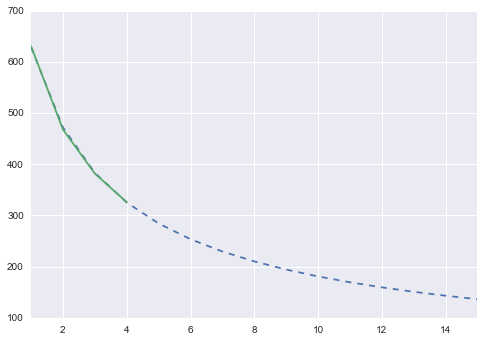

In [5]:
sn.set(color_codes=True)
Output['Remaining'].plot(linestyle='dashed')
Data['Remaining'].plot()